In [307]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve, confusion_matrix, classification_report)

import joblib
import pickle
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


In [15]:
df = pd.read_csv('data/diabetes_prediction_dataset.csv')
print('Original shape:', df.shape)
df.head()

Original shape: (100000, 9)


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [17]:
for col in df.columns:
    print(col)
    print(df[col].unique(), '\n')

gender
['Female' 'Male' 'Other'] 

age
[80.   54.   28.   36.   76.   20.   44.   79.   42.   32.   53.   78.
 67.   15.   37.   40.    5.   69.   72.    4.   30.   45.   43.   50.
 41.   26.   34.   73.   77.   66.   29.   60.   38.    3.   57.   74.
 19.   46.   21.   59.   27.   13.   56.    2.    7.   11.    6.   55.
  9.   62.   47.   12.   68.   75.   22.   58.   18.   24.   17.   25.
  0.08 33.   16.   61.   31.    8.   49.   39.   65.   14.   70.    0.56
 48.   51.   71.    0.88 64.   63.   52.    0.16 10.   35.   23.    0.64
  1.16  1.64  0.72  1.88  1.32  0.8   1.24  1.    1.8   0.48  1.56  1.08
  0.24  1.4   0.4   0.32  1.72  1.48] 

hypertension
[0 1] 

heart_disease
[1 0] 

smoking_history
['never' 'No Info' 'current' 'former' 'ever' 'not current'] 

bmi
[25.19 27.32 23.45 ... 59.42 44.39 60.52] 

HbA1c_level
[6.6 5.7 5.  4.8 6.5 6.1 6.  5.8 3.5 6.2 4.  4.5 9.  7.  8.8 8.2 7.5 6.8] 

blood_glucose_level
[140  80 158 155  85 200 145 100 130 160 126 159  90 260 220 300 280 2

In [18]:
len(df[df.gender == 'Other'])

18

In [19]:
df = df[df['gender'] != 'Other'].copy()
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})

# Replace 'No Info' with 'unknown' in smoking_history
df['smoking_history'] = df['smoking_history'].replace('No Info', 'unknown')

# Derived features (these are okay -- they are deterministic transformations of existing features)
df['bmi_per_age'] = df['bmi'] / (df['age'].replace(0, np.nan))
df['glucose_HbA1c_ratio'] = df['blood_glucose_level'] / (df['HbA1c_level'].replace(0, np.nan))
df['is_elderly'] = (df['age'] > 60).astype(int)
df['is_obese'] = (df['bmi'] >= 30).astype(int)

# Fill any infinite / NaN results from divisions
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

print('After basic cleaning:', df.shape)
df.head()

After basic cleaning: (99982, 13)


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,bmi_per_age,glucose_HbA1c_ratio,is_elderly,is_obese
0,0,80.0,0,1,never,25.19,6.6,140,0,0.314875,21.212121,1,0
1,0,54.0,0,0,unknown,27.32,6.6,80,0,0.505926,12.121212,0,0
2,1,28.0,0,0,never,27.32,5.7,158,0,0.975714,27.719298,0,0
3,0,36.0,0,0,current,23.45,5.0,155,0,0.651389,31.000000,0,0
4,1,76.0,1,1,current,20.14,4.8,155,0,0.265000,32.291667,1,0


In [30]:
numeric_features = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'bmi_per_age', 'glucose_HbA1c_ratio']
categorical_features = ['smoking_history', 'gender', 'hypertension', 'heart_disease', 'is_elderly', 'is_obese']

### EDA

In [22]:
df.describe()

,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,bmi_per_age,glucose_HbA1c_ratio,is_elderly,is_obese
count,99982.000000,99982.000000,99982.000000,99982.000000,99982.000000,99982.000000,99982.000000,99982.000000,99982.000000,99982.000000,99982.000000,99982.000000
mean,0.414375,41.888076,0.074863,0.039427,27.320757,5.527529,138.057810,0.085015,1.633643,25.828335,0.236363,0.235342
std,0.492616,22.517206,0.263172,0.194610,6.636853,1.070665,40.709469,0.278906,6.303683,8.746825,0.424850,0.424215
min,0.000000,0.080000,0.000000,0.000000,10.010000,3.500000,80.000000,0.000000,0.125125,12.121212,0.000000,0.000000
25%,0.000000,24.000000,0.000000,0.000000,23.630000,4.800000,100.000000,0.000000,0.473621,20.000000,0.000000,0.000000
50%,0.000000,43.000000,0.000000,0.000000,27.320000,5.800000,140.000000,0.000000,0.682895,24.615385,0.000000,0.000000
75%,1.000000,60.000000,0.000000,0.000000,29.580000,6.200000,159.000000,0.000000,1.141500,31.500000,0.000000,0.000000
max,1.000000,80.000000,1.000000,1.000000,95.690000,9.000000,300.000000,1.000000,383.000000,57.142857,1.000000,1.000000


<Axes: xlabel='diabetes', ylabel='count'>

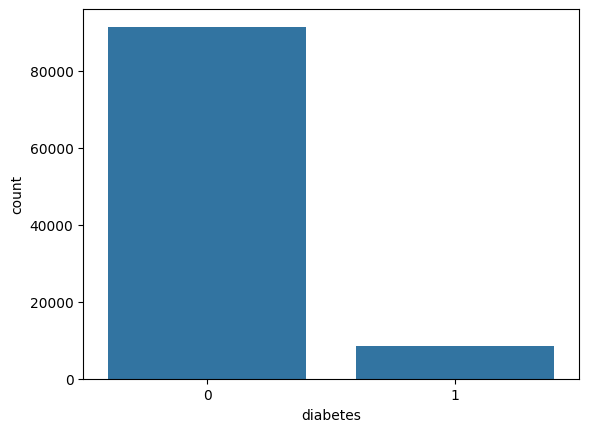

In [23]:
sns.countplot(x='diabetes', data=df)

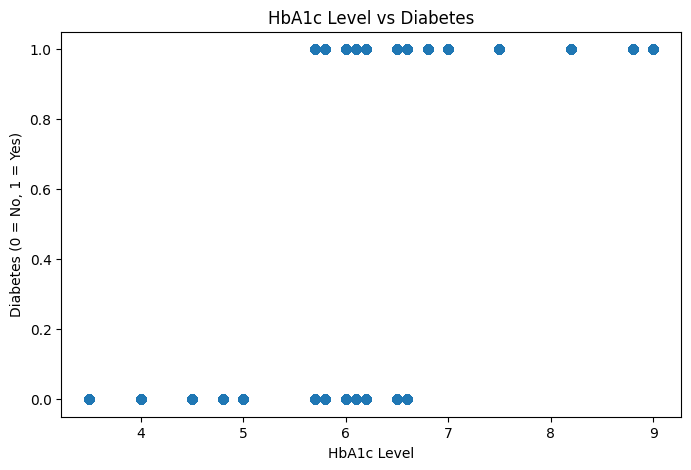

In [315]:
plt.figure(figsize=(8,5))
plt.scatter(df['HbA1c_level'], df['diabetes'], alpha=0.3)
plt.xlabel("HbA1c Level")
plt.ylabel("Diabetes (0 = No, 1 = Yes)")
plt.title("HbA1c Level vs Diabetes")
plt.show()

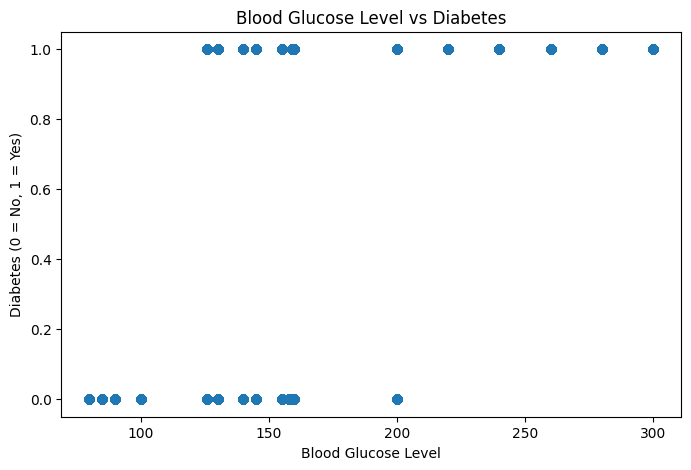

In [316]:
plt.figure(figsize=(8,5))
plt.scatter(df['blood_glucose_level'], df['diabetes'], alpha=0.3)
plt.xlabel("Blood Glucose Level")
plt.ylabel("Diabetes (0 = No, 1 = Yes)")
plt.title("Blood Glucose Level vs Diabetes")
plt.show()

In [24]:
class_counts = df['diabetes'].value_counts()
class_percentages = df['diabetes'].value_counts(normalize=True) * 100

print("Class distribution:")
print(class_counts)
print("\nClass percentage:")
print(class_percentages)

Class distribution:
diabetes
0    91482
1     8500
Name: count, dtype: int64

Class percentage:
diabetes
0    91.49847
1     8.50153
Name: proportion, dtype: float64


-- Dataset has class imbalance which needs to be dealed with to avoid overfitting to only class 

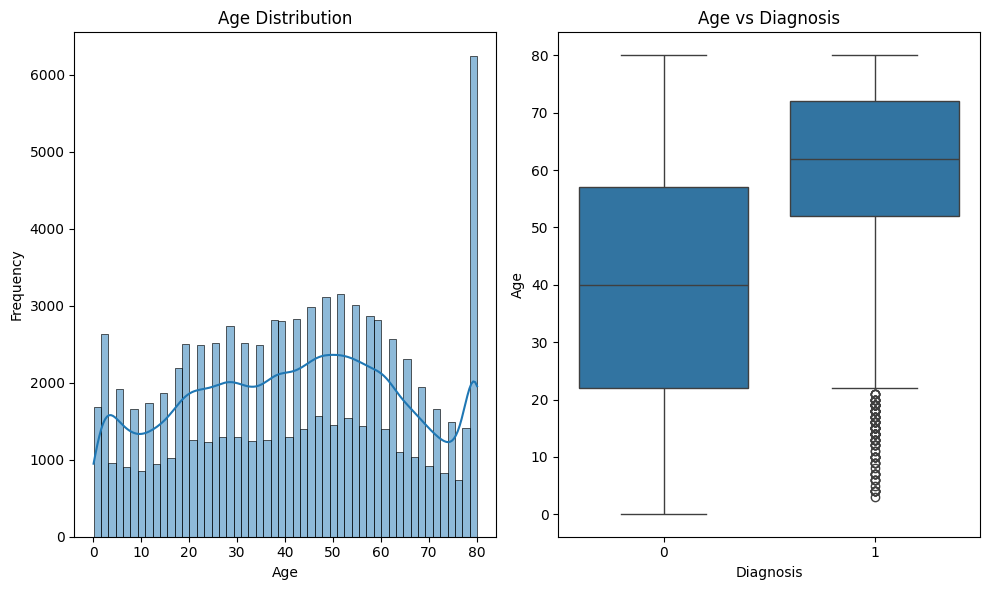

In [25]:
# Age vs Diabetes
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.histplot(df.age, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.boxplot(x='diabetes', y='age', data=df)
plt.title('Age vs Diagnosis')
plt.xlabel('Diagnosis')
plt.ylabel('Age')
plt.tight_layout()
plt.show()

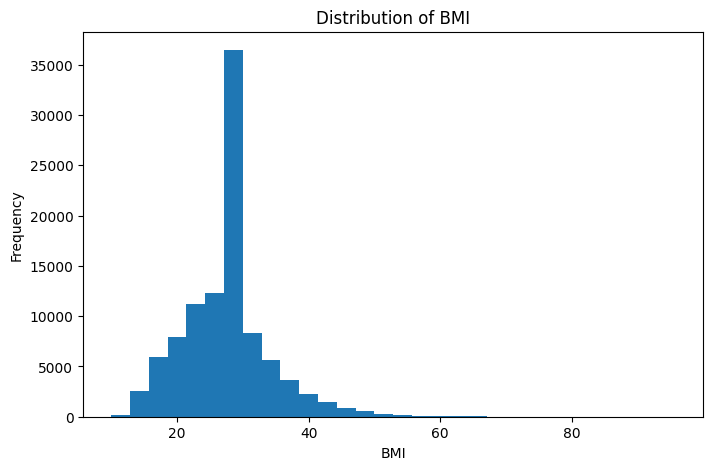

In [26]:
plt.figure(figsize=(8,5))
plt.hist(df["bmi"], bins=30)
plt.xlabel("BMI")
plt.ylabel("Frequency")
plt.title("Distribution of BMI")
plt.show()

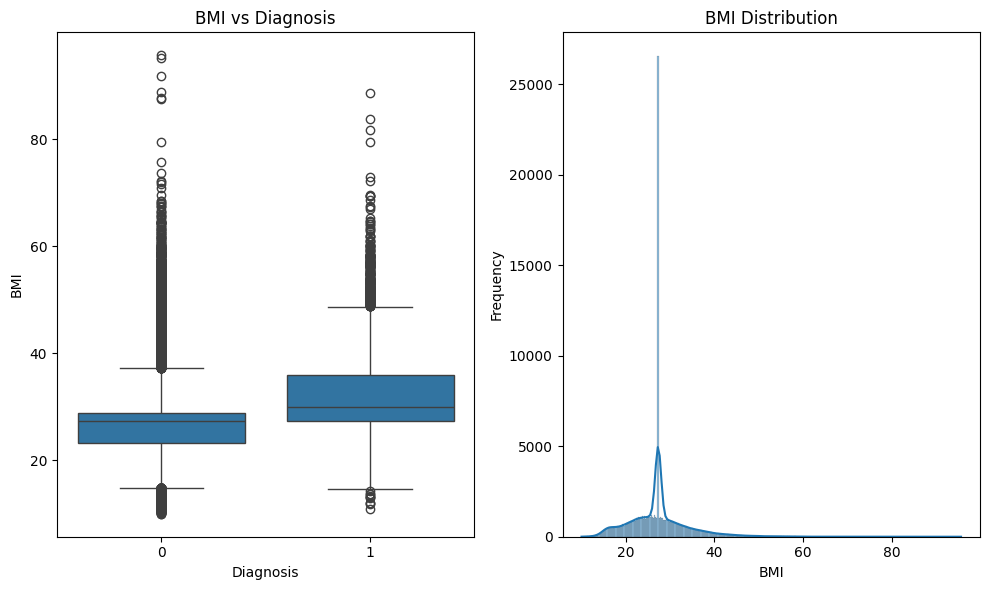

In [27]:
# BMI vs Diabetes
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='diabetes', y='bmi', data=df)
plt.title('BMI vs Diagnosis')
plt.xlabel('Diagnosis')
plt.ylabel('BMI')

plt.subplot(1, 2, 2)
sns.histplot(df.bmi, kde=True)
plt.title('BMI Distribution')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

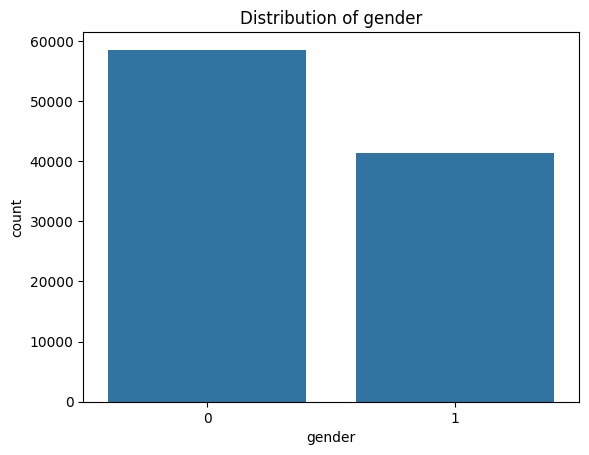

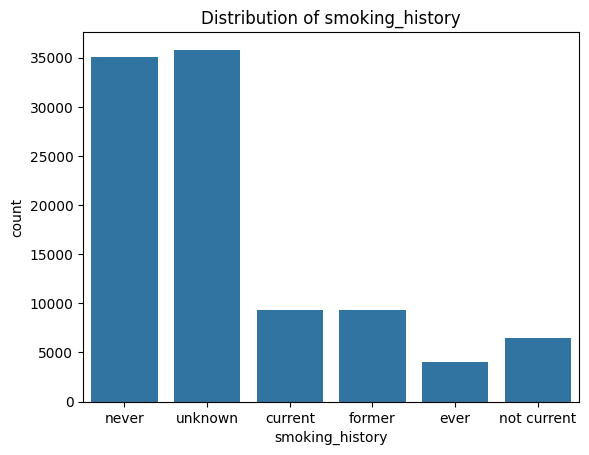

In [28]:
for col in ['gender', 'smoking_history']:
    sns.countplot(data=df, x=col)
    plt.title(f'Distribution of {col}')
    plt.show()

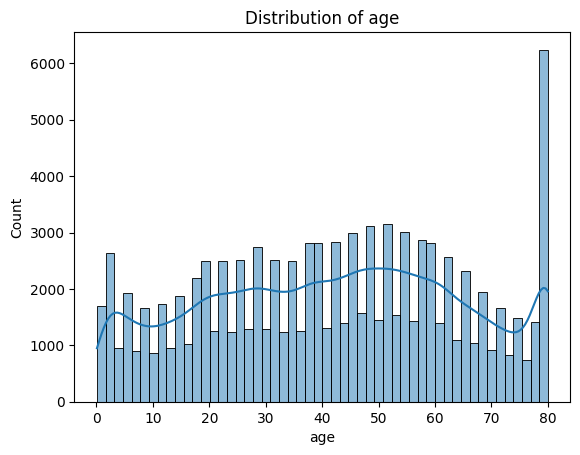

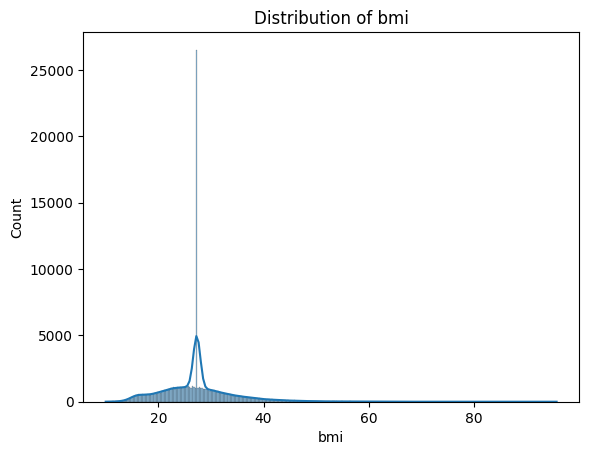

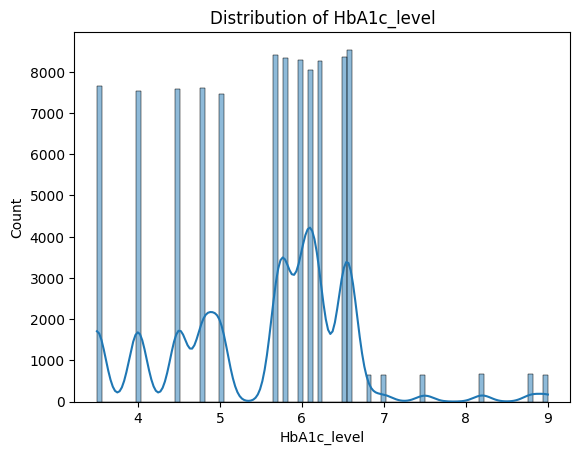

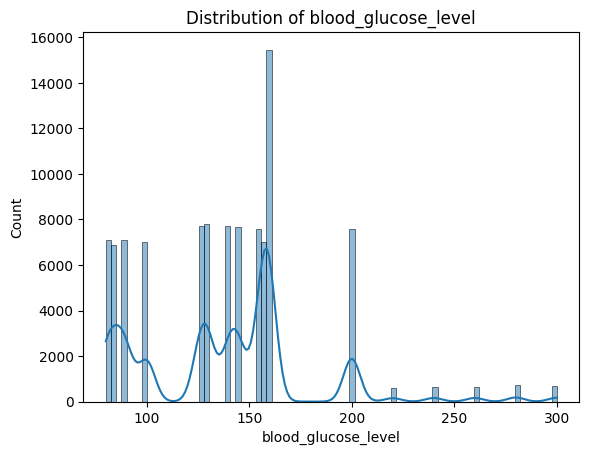

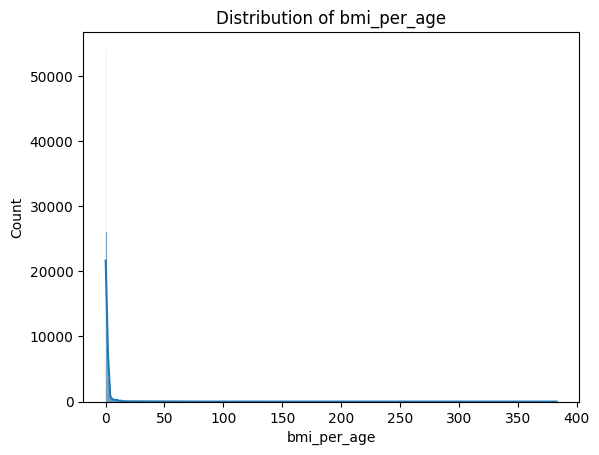

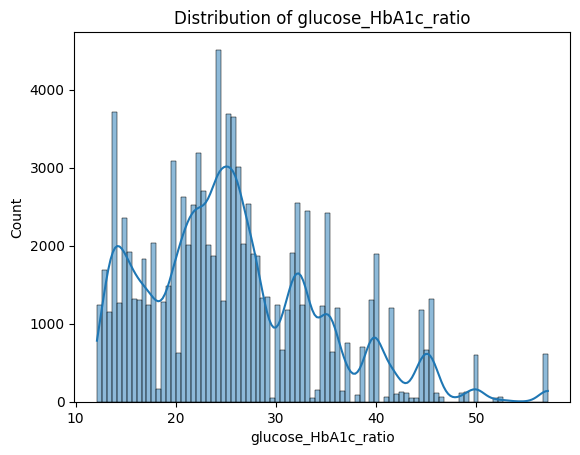

In [31]:
for col in numeric_features:
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

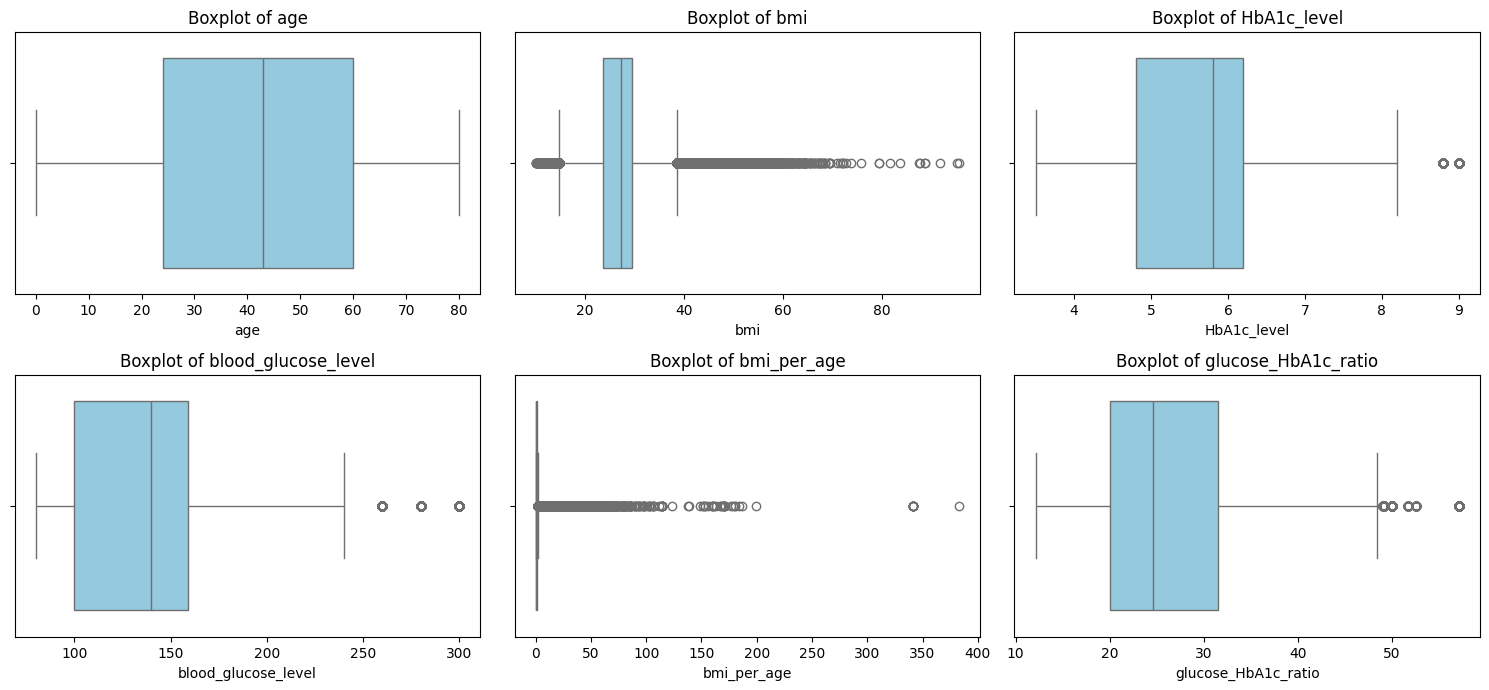

In [32]:
plt.figure(figsize=(15, 10))

for i, col in enumerate(numeric_features, 1):
    plt.subplot(3, 3, i)  
    sns.boxplot(x=df[col], color='skyblue')
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)

plt.tight_layout()
plt.show()

In [33]:
df_encoded = pd.get_dummies(df, drop_first=True)
df_encoded.corr()['diabetes'].sort_values(ascending=False)

diabetes                       1.000000
blood_glucose_level            0.419587
HbA1c_level                    0.400696
age                            0.257999
is_elderly                     0.228742
bmi                            0.214377
hypertension                   0.197811
is_obese                       0.188733
heart_disease                  0.171718
smoking_history_former         0.097901
glucose_HbA1c_ratio            0.097456
gender                         0.037623
smoking_history_never          0.027248
smoking_history_ever           0.024088
smoking_history_not current    0.020831
bmi_per_age                   -0.050988
smoking_history_unknown       -0.118953
Name: diabetes, dtype: float64

### Training

In [106]:
def evaluate_model(model, model_name, X_test, y_test, results_df=None):
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # ROC AUC (handle cases where predict_proba is not available)
    if y_pred_proba is not None:
        roc_auc = roc_auc_score(y_test, y_pred_proba)
    else:
        roc_auc = None
    
    # Create results dictionary
    results = {
        'Model': model_name,
        'Accuracy': round(accuracy, 4),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1 Score': round(f1, 4),
        'ROC AUC': round(roc_auc, 4) if roc_auc is not None else 'N/A'
    }
    
    # Create or append to DataFrame
    if results_df is None:
        results_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'])
    
    results_df = pd.concat([results_df, pd.DataFrame([results])], ignore_index=True)
    print(f"Model: {results['Model']}")   
    print(f"Accuracy: {results['Accuracy']}")
    print(f"Precision: {results['Precision']}")
    print(f"Recall: {results['Recall']}")
    print(f"F1 Score: {results['F1 Score']}")
    print(f"ROC AUC: {results['ROC AUC']}")

    return results_df

In [89]:
result_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'])

In [36]:
X = df[numeric_features + categorical_features].copy()
y = df['diabetes'].astype(int).values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

Train shape: (79985, 12) Test shape: (19997, 12)


In [39]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ]
)


X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_processed, y_train)

In [93]:
preprocessor_one_hot_encoding = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ]
)


X_train_processed_one_hot_encoding = preprocessor_one_hot_encoding.fit_transform(X_train)
X_test_processed_one_hot_encoding = preprocessor_one_hot_encoding.transform(X_test)

In [91]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train_res, y_train_res)
result_df = evaluate_model(lr, 'Logistic Regression Standard Scaled and Resampled', X_test_processed, y_test, result_df)

In [95]:
unscaled_unsampled_lr = LogisticRegression(random_state=42)
unscaled_unsampled_lr.fit(X_train_processed_one_hot_encoding, y_train)

result_df = evaluate_model(unscaled_unsampled_lr, 'Logistic Regression', X_test_processed_one_hot_encoding, y_test, result_df)

In [123]:
lr_balanced = LogisticRegression(random_state=42, class_weight='balanced')
lr_balanced.fit(X_train_processed, y_train)
result_df = evaluate_model(lr_balanced, 'Logistic Regression Standard Scaled Balanced Weights No Resampling', X_test_processed, y_test, result_df)

Model: Logistic Regression Standard Scaled Balanced Weights No Resampling
Accuracy: 0.8869
Precision: 0.4217
Recall: 0.8906
F1 Score: 0.5724
ROC AUC: 0.9627


In [128]:
from imblearn.pipeline import Pipeline as ImbPipeline


pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(random_state=42))
])


param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga'],
    'classifier__max_iter': [1000, 2000]
}

# Perform grid search
grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'classifier__C': 0.001, 'classifier__max_iter': 1000, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}
Best cross-validation score: 0.8876039257360755


In [49]:
best_params = grid_search.best_params_
best_params

{'classifier__C': 0.001,
 'classifier__max_iter': 1000,
 'classifier__penalty': 'l2',
 'classifier__solver': 'saga'}

In [50]:
grid_search.best_estimator_

,steps,"[('preprocessor', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [99]:
parameter_tuned_lr = grid_search.best_estimator_

In [56]:
(y_pred == y_test).mean()

np.float64(0.8886833024953743)

In [100]:
result_df = evaluate_model(parameter_tuned_lr, 'Logistic Regression Parameter Tuned', X_test, y_test, result_df)

### DescisionTree

In [102]:
dt = DecisionTreeClassifier(random_state=42)

dt.fit(X_train_res, y_train_res)

result_df = evaluate_model(dt, 'Decision Tree Classifier Standard Scaled and Resampled', X_test_processed, y_test, result_df)

In [107]:
unscaled_unsampled_dt = DecisionTreeClassifier(random_state=42)

unscaled_unsampled_dt.fit(X_train_processed_one_hot_encoding, y_train)

result_df = evaluate_model(unscaled_unsampled_dt, 'Decision Tree Classifier', X_test_processed_one_hot_encoding, y_test, result_df)

Model: Decision Tree Classifier
Accuracy: 0.9147
Precision: 0.4468
Recall: 0.0124
F1 Score: 0.024
ROC AUC: 0.8064


In [125]:
dt_balanced = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt_balanced.fit(X_train_processed, y_train)
result_df = evaluate_model(dt_balanced, 'Decision Tree Standard Scaled Balanced Weights No Resampling', X_test_processed, y_test, result_df)

Model: Decision Tree Standard Scaled Balanced Weights No Resampling
Accuracy: 0.953
Precision: 0.7183
Recall: 0.7365
F1 Score: 0.7273
ROC AUC: 0.8553


In [109]:
dt_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

dt_param_grid = {
    'classifier__criterion': ['gini'],
    'classifier__max_depth': [5, 10, 15],
    'classifier__min_samples_split': [5, 10],
    'classifier__min_samples_leaf': [2, 4],
    'classifier__max_features': ['sqrt'],
    'classifier__splitter': ['best']
}

dt_grid_search = GridSearchCV(
    dt_pipeline, 
    dt_param_grid, 
    cv=3, 
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

dt_grid_search.fit(X_train, y_train)

print("Best Decision Tree parameters:", dt_grid_search.best_params_)
print("Best Decision Tree cross-validation score:", dt_grid_search.best_score_)

best_dt_model = dt_grid_search.best_estimator_

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Decision Tree parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 15, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 5, 'classifier__splitter': 'best'}
Best Decision Tree cross-validation score: 0.9217102486014831


In [110]:
result_df = evaluate_model(best_dt_model, 'Decision Tree Classifier Parameter Tuned', X_test, y_test, result_df)

Model: Decision Tree Classifier Parameter Tuned
Accuracy: 0.9197
Precision: 0.5172
Recall: 0.84
F1 Score: 0.6402
ROC AUC: 0.9548


In [111]:
result_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression Standard Scaled and Resampled,0.8867,0.4211,0.8888,0.5715,0.9627
1,Logistic Regression,0.9135,0.4505,0.0776,0.1325,0.8057
2,Logistic Regression Parameter Tuned,0.8887,0.4257,0.8871,0.5754,0.9623
3,Decision Tree Classifier Standard Scaled and R...,0.9496,0.6864,0.7494,0.7165,0.8592
4,Decision Tree Classifier,0.9147,0.4468,0.0124,0.0240,0.8064
5,Decision Tree Classifier Parameter Tuned,0.9197,0.5172,0.8400,0.6402,0.9548


### RandomForest

In [112]:
rf = RandomForestClassifier(random_state=42)

rf.fit(X_train_res, y_train_res)

result_df = evaluate_model(rf, 'Random Forest Classifier Standard Scaled and Resampled', X_test_processed, y_test, result_df)

Model: Random Forest Classifier Standard Scaled and Resampled
Accuracy: 0.9596
Precision: 0.7765
Recall: 0.7376
F1 Score: 0.7566
ROC AUC: 0.97


In [113]:
unscaled_unsampled_rf = RandomForestClassifier(random_state=42)

unscaled_unsampled_rf.fit(X_train_processed_one_hot_encoding, y_train)

result_df = evaluate_model(unscaled_unsampled_rf, 'Random Forest Classifier', X_test_processed_one_hot_encoding, y_test, result_df)

Model: Random Forest Classifier
Accuracy: 0.9145
Precision: 0.4182
Recall: 0.0135
F1 Score: 0.0262
ROC AUC: 0.8065


In [126]:
rf_balanced = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)
rf_balanced.fit(X_train_processed, y_train)
result_df = evaluate_model(rf_balanced, 'Random Forest Standard Scaled Balanced Weights No Resampling', X_test_processed, y_test, result_df)

Model: Random Forest Standard Scaled Balanced Weights No Resampling
Accuracy: 0.9707
Precision: 0.9551
Recall: 0.6876
F1 Score: 0.7996
ROC AUC: 0.9682


In [114]:

rf_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

rf_param_grid = {
    'classifier__n_estimators': [100],
    'classifier__max_depth': [10, None],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1],
    'classifier__max_features': ['sqrt'],
    'classifier__criterion': ['gini']
}

rf_grid_search = GridSearchCV(
    rf_pipeline, 
    rf_param_grid, 
    cv=3, 
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

rf_grid_search.fit(X_train, y_train)

print("Best Random Forest parameters:", rf_grid_search.best_params_)
print("Best Random Forest cross-validation score:", rf_grid_search.best_score_)

best_rf_model = rf_grid_search.best_estimator_

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Random Forest parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Best Random Forest cross-validation score: 0.9597049518548159


In [115]:
result_df = evaluate_model(best_rf_model, 'Random Forest Classifier Parameter Tuned', X_test, y_test, result_df)

Model: Random Forest Classifier Parameter Tuned
Accuracy: 0.9596
Precision: 0.7765
Recall: 0.7376
F1 Score: 0.7566
ROC AUC: 0.97


### Gradient Boosting

In [116]:
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train_res, y_train_res)

result_df = evaluate_model(gb, 'Gradient Boosting Classifier Standard Scaled and Resampled', X_test_processed, y_test, result_df)

Model: Gradient Boosting Classifier Standard Scaled and Resampled
Accuracy: 0.9568
Precision: 0.7286
Recall: 0.7847
F1 Score: 0.7556
ROC AUC: 0.9768


In [117]:
unscaled_unsampled_gb = GradientBoostingClassifier(random_state=42)

unscaled_unsampled_gb.fit(X_train_processed_one_hot_encoding, y_train)

result_df = evaluate_model(unscaled_unsampled_gb, 'Gradient Boosting Classifier', X_test_processed_one_hot_encoding, y_test, result_df)

Model: Gradient Boosting Classifier
Accuracy: 0.9146
Precision: 0.4054
Recall: 0.0088
F1 Score: 0.0173
ROC AUC: 0.8075


In [121]:
from sklearn.utils.class_weight import compute_class_weight

gb_balanced = GradientBoostingClassifier(random_state=42)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
sample_weights = class_weights[y_train]
gb_balanced.fit(X_train_processed, y_train, sample_weight=sample_weights)
result_df = evaluate_model(gb_balanced, 'Gradient Boosting Standard Scaled Balanced Weights No Resampling', X_test_processed, y_test, result_df)

Model: Gradient Boosting Standard Scaled Balanced Weights No Resampling
Accuracy: 0.9078
Precision: 0.4781
Recall: 0.92
F1 Score: 0.6292
ROC AUC: 0.9796


### Feature importance

In [322]:
importances = gb_balanced.feature_importances_

In [323]:
def get_feature_names(preprocessor):
    output_features = []

    for name, transformer, cols in preprocessor.transformers_:

        if name == 'remainder':
            continue

        if hasattr(transformer, 'get_feature_names_out'):

            names = transformer.get_feature_names_out(cols)
            output_features.extend(names)
        else:

            output_features.extend(cols)

    return output_features

In [324]:
feature_names = get_feature_names(preprocessor)
print(len(feature_names))
print(feature_names)

16
['age', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'bmi_per_age', 'glucose_HbA1c_ratio', 'smoking_history_ever', 'smoking_history_former', 'smoking_history_never', 'smoking_history_not current', 'smoking_history_unknown', 'gender_1', 'hypertension_1', 'heart_disease_1', 'is_elderly_1', 'is_obese_1']


In [325]:
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

feature_importance_df = feature_importance_df.sort_values(
    by='importance', ascending=False
).reset_index(drop=True)

print(feature_importance_df)

                        feature  importance
0                   HbA1c_level    0.491528
1           blood_glucose_level    0.340885
2                           age    0.122175
3                           bmi    0.026908
4                hypertension_1    0.007711
5           glucose_HbA1c_ratio    0.003608
6               heart_disease_1    0.002645
7       smoking_history_unknown    0.002440
8                   bmi_per_age    0.001157
9                      gender_1    0.000881
10  smoking_history_not current    0.000054
11         smoking_history_ever    0.000007
12       smoking_history_former    0.000000
13        smoking_history_never    0.000000
14                 is_elderly_1    0.000000
15                   is_obese_1    0.000000


In [129]:

gb_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', GradientBoostingClassifier(random_state=42))
])




gb_param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__max_depth': [3, 4],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__max_features': ['sqrt', None]
}

gb_grid_search = GridSearchCV(
    gb_pipeline, 
    gb_param_grid,  
    cv=3, 
    scoring='roc_auc',  
    n_jobs=-1,
    verbose=1
)

print("Starting Gradient Boosting Grid Search...")
gb_grid_search.fit(X_train, y_train)

print("Best Gradient Boosting parameters:", gb_grid_search.best_params_)
print("Best Gradient Boosting cross-validation score:", gb_grid_search.best_score_)

best_gb_model = gb_grid_search.best_estimator_

Starting Gradient Boosting Grid Search...
Fitting 3 folds for each of 64 candidates, totalling 192 fits
Best Gradient Boosting parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 4, 'classifier__max_features': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Best Gradient Boosting cross-validation score: 0.9781117234336731


In [130]:
result_df = evaluate_model(best_rf_model, 'Gradient Boosting Parameter Tuned', X_test, y_test, result_df)

Model: Gradient Boosting Parameter Tuned
Accuracy: 0.9596
Precision: 0.7765
Recall: 0.7376
F1 Score: 0.7566
ROC AUC: 0.97


In [131]:
result_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression Standard Scaled and Resampled,0.8867,0.4211,0.8888,0.5715,0.9627
1,Logistic Regression,0.9135,0.4505,0.0776,0.1325,0.8057
2,Logistic Regression Parameter Tuned,0.8887,0.4257,0.8871,0.5754,0.9623
3,Decision Tree Classifier Standard Scaled and R...,0.9496,0.6864,0.7494,0.7165,0.8592
4,Decision Tree Classifier,0.9147,0.4468,0.0124,0.0240,0.8064
5,Decision Tree Classifier Parameter Tuned,0.9197,0.5172,0.8400,0.6402,0.9548
6,Random Forest Classifier Standard Scaled and R...,0.9596,0.7765,0.7376,0.7566,0.9700
7,Random Forest Classifier,0.9145,0.4182,0.0135,0.0262,0.8065
8,Random Forest Classifier Parameter Tuned,0.9596,0.7765,0.7376,0.7566,0.9700
9,Gradient Boosting Classifier Standard Scaled a...,0.9568,0.7286,0.7847,0.7556,0.9768


In [137]:
result_df.sort_values(by='Recall', ascending=False)

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
11,Gradient Boosting Standard Scaled Balanced Wei...,0.9078,0.4781,0.9200,0.6292,0.9796
12,Logistic Regression Standard Scaled Balanced W...,0.8869,0.4217,0.8906,0.5724,0.9627
0,Logistic Regression Standard Scaled and Resampled,0.8867,0.4211,0.8888,0.5715,0.9627
2,Logistic Regression Parameter Tuned,0.8887,0.4257,0.8871,0.5754,0.9623
5,Decision Tree Classifier Parameter Tuned,0.9197,0.5172,0.8400,0.6402,0.9548
9,Gradient Boosting Classifier Standard Scaled a...,0.9568,0.7286,0.7847,0.7556,0.9768
3,Decision Tree Classifier Standard Scaled and R...,0.9496,0.6864,0.7494,0.7165,0.8592
6,Random Forest Classifier Standard Scaled and R...,0.9596,0.7765,0.7376,0.7566,0.9700
15,Gradient Boosting Parameter Tuned,0.9596,0.7765,0.7376,0.7566,0.9700
8,Random Forest Classifier Parameter Tuned,0.9596,0.7765,0.7376,0.7566,0.9700


In [138]:
gb_balanced

,loss,'log_loss'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None
